# Batch Normalization, Dropout, MNIST

This notebook compares the effects of batch normalization and dropout on the performance of LeNet-5 using the MNIST dataset. It also explores the combination of both techniques.

## Overview
The key steps involve training the network with different normalization techniques, comparing performance, and analyzing the effects of dropout and batch normalization.

## Procedure
- **Co-Adaptation and Internal Covariate Shift**: Explain these terms and their significance.
- **Standard Normalization and Batch Normalization**: Train LeNet-5 with standard normalization for input and batch normalization for hidden layers, and analyze the learned parameters.
- **Batch Normalization for Input Layer**: Train the network with batch normalization for the input layer and compare performance with standard normalization.
- **Dropout**: Train the network using dropout and compare the performance with batch normalization.
- **Combination of Techniques**: Train the network using both batch normalization and dropout, and compare the performance with previous experiments.

In [1]:


from keras.datasets import mnist
import pandas as pd
from tensorflow import keras

import numpy as np
from sklearn.preprocessing import StandardScaler


def get_mnist(scale:bool):
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = np.expand_dims(x_train, -1).astype('float32') / 255.0
    x_test = np.expand_dims(x_test, -1).astype('float32') / 255.0
    if scale:
        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train.reshape(-1, 28*28)).reshape(-1, 28, 28, 1)
        x_test = scaler.fit_transform(x_test.reshape(-1, 28*28)).reshape(-1, 28, 28, 1)
    y_train = keras.utils.to_categorical(y_train, 10)
    y_test = keras.utils.to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test


x_train, y_train, x_test, y_test = get_mnist(scale=True)


print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)



x_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
x_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


## Co-adaptation

- Co-adaptation refers to the phenomenon where model elements become overly dependent on each other. This can lead to overfitting.
  
- Example: Image recognition neurons focusing on the same patterns too heavily.

## Covariance Shift

- Covariance shift describes the change in data statistics as they pass through a deep neural network's layers. This makes training slower and less reliable. This makes the models results dependent on the input distribution.
  
- Example: Input values to filters in image analysis networks change due to image processing steps.


In [2]:
# get location of tensorflow library
import os
import inspect
import tensorflow as tf
keras = tf.keras
from keras import layers, models, Sequential, optimizers



## 5.2


In [3]:
model = keras.Sequential([
    layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.Dense(84, activation='relu'),
    layers.Dense(10, activation='softmax')
])


In [5]:

import tensorflow as tf
keras = tf.keras
from keras import layers
import tensorflow as tf

x_train, y_train, x_test, y_test = get_mnist(scale=False)

standardNormalizer = layers.Normalization(axis=None)
standardNormalizer.adapt(x_train)
normalized_x_train = standardNormalizer(x_train)
normalized_x_test  = standardNormalizer(x_test)


model = keras.Sequential([
    layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(84, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
])

model.summary()
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

device = 'CPU'
batch_size = 128
epochs = 10

with tf.device(f'/device:{device}:0'):
    history = model.fit(normalized_x_train, y_train, batch_size=128, epochs=10, validation_data=(normalized_x_test, y_test))



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 6)         156       
                                                                 
 batch_normalization_4 (Bat  (None, 24, 24, 6)         24        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 16)          2416      
                                                                 
 batch_normalization_5 (Bat  (None, 8, 8, 16)          64        
 chNormalization)                                                
                                                      

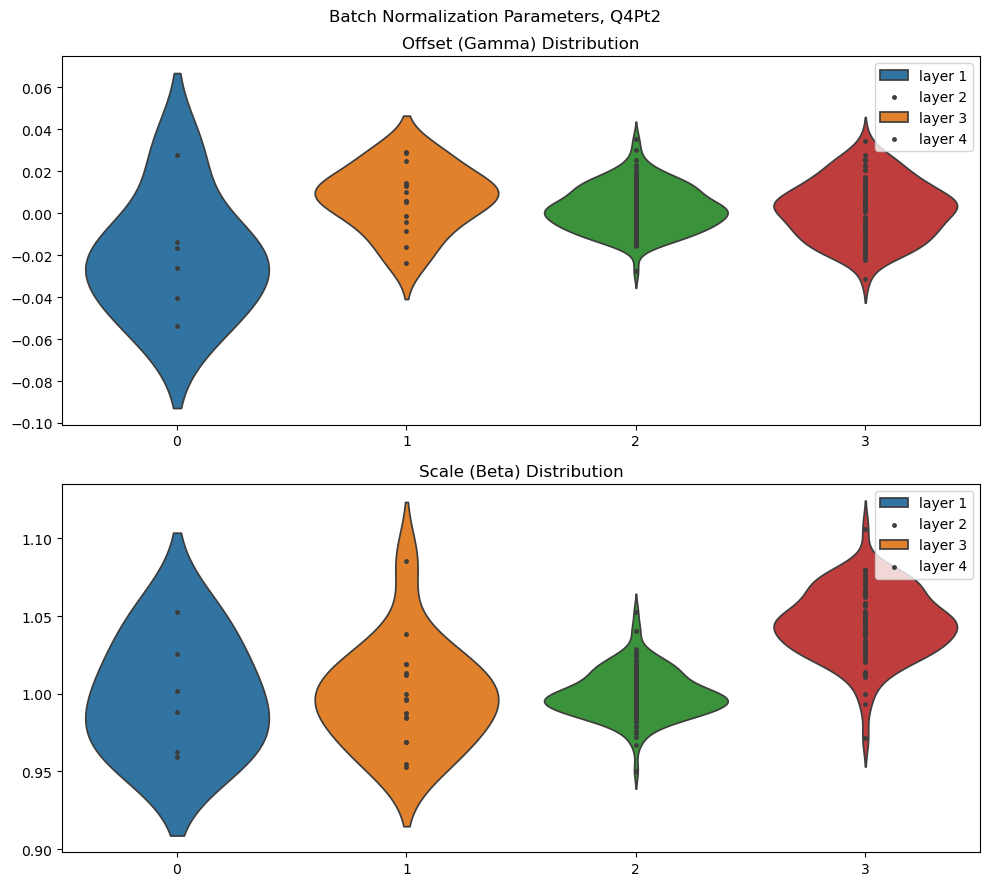

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


# Extract Nomalization parameters for each layer
bn_layers = [layer for layer in history.model.layers if 'batch_normalization' in layer.name]
gammas = [layer.get_weights()[0] for layer in bn_layers]
betas = [layer.get_weights()[1] for layer in bn_layers]

fig = plt.figure(figsize=(10, 9))

plt.subplot(2, 1, 1)
sns.violinplot(data=betas, inner="point", orient="v")
plt.title('Offset (Gamma) Distribution')
plt.legend([f'layer {i+1}' for i in range(len(gammas))])

plt.subplot(2, 1, 2)
sns.violinplot(data=gammas, inner="point", orient="v")
plt.title('Scale (Beta) Distribution')
plt.legend([f'layer {i+1}' for i in range(len(gammas))])

plt.suptitle('Batch Normalization Parameters, Q4Pt2')

plt.tight_layout()
plt.show()


### Problem 4 Part 3


In [15]:
layers.BatchNormalization
model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(84, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

device = 'CPU'
batch_size = 128
epochs = 10
x_train, y_train, x_test, y_test = get_mnist(scale=True)

with tf.device(f'/device:{device}:0'):
    historyInitBN = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))


Epoch 1/10
469/469 [==============================] - 6s 12ms/step - loss: 0.4712 - accuracy: 0.8705 - val_loss: 0.1880 - val_accuracy: 0.9528
Epoch 2/10
469/469 [==============================] - 5s 11ms/step - loss: 0.1715 - accuracy: 0.9536 - val_loss: 0.1219 - val_accuracy: 0.9659
Epoch 3/10
469/469 [==============================] - 5s 11ms/step - loss: 0.1259 - accuracy: 0.9654 - val_loss: 0.0974 - val_accuracy: 0.9724
Epoch 4/10
469/469 [==============================] - 5s 11ms/step - loss: 0.1010 - accuracy: 0.9716 - val_loss: 0.0821 - val_accuracy: 0.9759
Epoch 5/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0870 - accuracy: 0.9752 - val_loss: 0.0742 - val_accuracy: 0.9772
Epoch 6/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0764 - accuracy: 0.9787 - val_loss: 0.0665 - val_accuracy: 0.9793
Epoch 7/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0691 - accuracy: 0.9801 - val_loss: 0.0618 - val_accuracy: 0.9817

In [17]:
# test and train accuracy
train_accuracy = historyInitBN.history['accuracy']
test_accuracy = historyInitBN.history['val_accuracy']

train_accuracy_og = history.history['accuracy']
test_accuracy_og = history.history['val_accuracy']
import rich

rich.print(f'4.2: train_accuracy: {train_accuracy_og[-1]*100:.2f}%')
rich.print(f'4.2: test_accuracy: {test_accuracy_og[-1]*100:.2f}%')

rich.print(f'4.3: train_accuracy: {train_accuracy[-1]*100:.2f}%')
rich.print(f'4.3: test_accuracy: {test_accuracy[-1]*100:.2f}%')


4.2 train_accuracy: 98.64%

4.2 test_accuracy: 98.50%

4.3 train_accuracy: 98.53%

4.3 test_accuracy: 98.38%

Text(0.5, 0.98, 'Batch Normalization Parameters w/ Input BN, Q4Pt3')

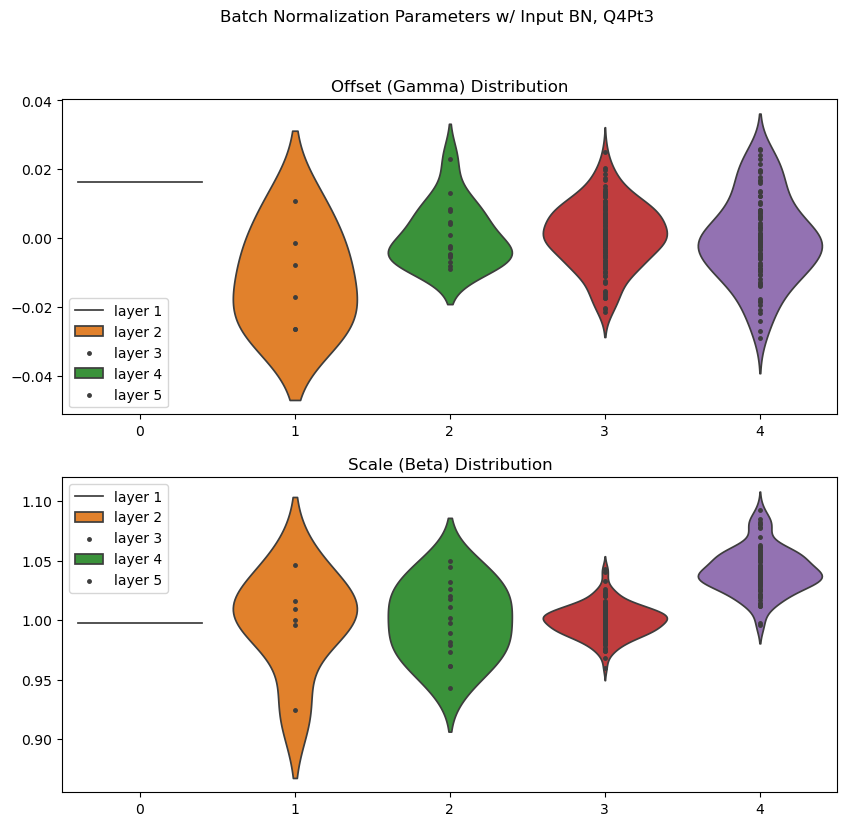

In [8]:

bn_layers = [layer for layer in historyInitBN.model.layers if 'batch_normalization' in layer.name]
gammas_2 = [layer.get_weights()[0] for layer in bn_layers]
betas_2 = [layer.get_weights()[1] for layer in bn_layers]

fig = plt.figure(figsize=(10, 9))


plt.subplot(2, 1, 1)
sns.violinplot(data=betas_2, inner="point", orient="v")
plt.title('Offset (Gamma) Distribution')
plt.legend([f'layer {i+1}' for i in range(len(betas_2))])

plt.subplot(2, 1, 2)
sns.violinplot(data=gammas_2, inner="point", orient="v")
plt.title('Scale (Beta) Distribution')
plt.legend([f'layer {i+1}' for i in range(len(betas_2))])


plt.suptitle('Batch Normalization Parameters w/ Input BN, Q4Pt3')


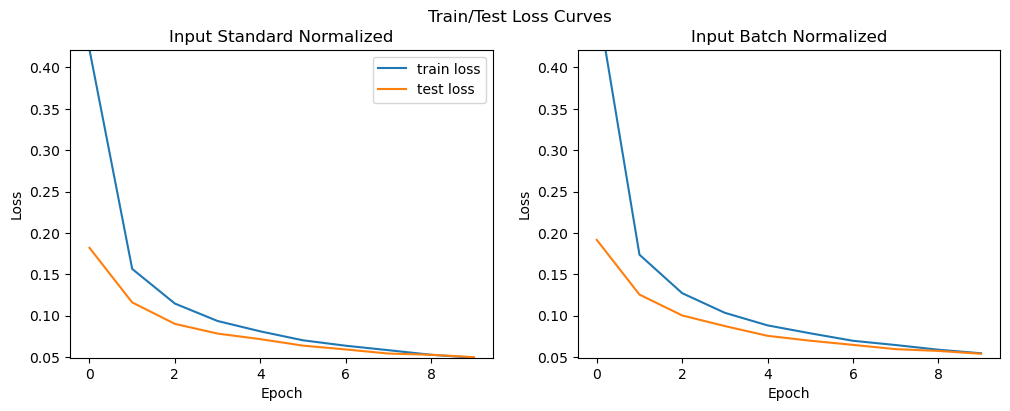

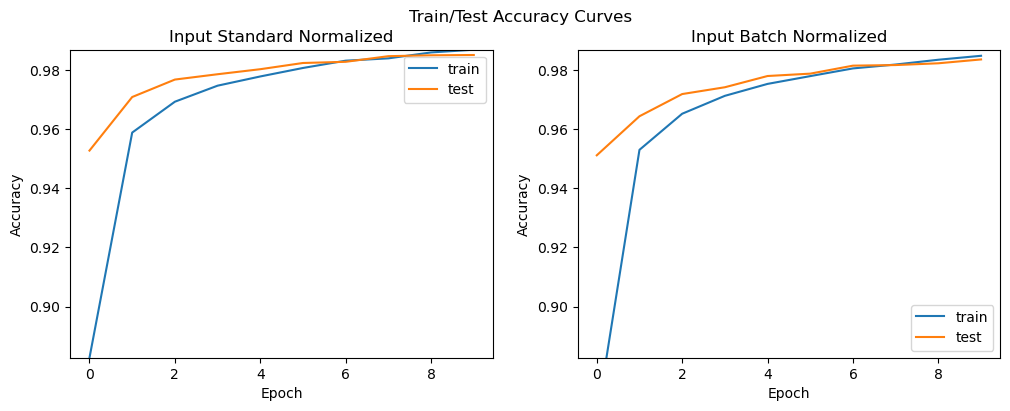

In [13]:
# plot test/train loss and accuracy

# Train/Test Loss and Accuracy w/ Input Standard Normalized
train_loss_m1, test_loss_m1 = history.history['loss'], history.history['val_loss']
train_accuracy_m1, test_accuracy_m1 = history.history['accuracy'], history.history['val_accuracy']


# Train/Test Loss and Accuracy w/ Init Batch Normalized
train_loss_m2, test_loss_m2 = historyInitBN.history['loss'], historyInitBN.history['val_loss']
train_accuracy_m2, test_accuracy_m2 = historyInitBN.history['accuracy'], historyInitBN.history['val_accuracy']


#  compare the train/test accuracy and loss for the two cases, by plotting them over epochs


# ylim for both
ymin, ymax = min(min(train_loss_m1), min(test_loss_m1)), max(max(train_loss_m1), max(test_loss_m1))


plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_m1, label='train loss')
plt.plot(test_loss_m1, label='test loss')
plt.ylim(ymin, ymax)
plt.title('Input Standard Normalized')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_m2, label='train loss')
plt.plot(test_loss_m2, label='test loss')
plt.ylim(ymin, ymax)
plt.title('Input Batch Normalized')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.suptitle('Train/Test Loss Curves')



plt.figure(figsize=(12, 4))

# ylim for both
ymin, ymax = min(min(train_accuracy_m1), min(test_accuracy_m1)), max(max(train_accuracy_m1), max(test_accuracy_m1))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy_m1, label='train')
plt.plot(test_accuracy_m1, label='test')
plt.ylim(ymin, ymax)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Input Standard Normalized')

# store fig in variable to be added to later but still show now
loss_fig = plt.gcf()



plt.subplot(1, 2, 2)
plt.plot(train_accuracy_m2, label='train')
plt.plot(test_accuracy_m2, label='test')
plt.ylim(ymin, ymax)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Input Batch Normalized')

plt.suptitle('Train/Test Accuracy Curves')


acc_fig = plt.gcf()






In [ ]:
# test and train accuracy
train_accuracy = historyInitBN.history['accuracy']
test_accuracy = historyInitBN.history['val_accuracy']

train_accuracy_og = history.history['accuracy']
test_accuracy_og = history.history['val_accuracy']
import rich

rich.print(f'4.2: train_accuracy: {train_accuracy_og[-1]*100:.2f}%')
rich.print(f'4.2: test_accuracy: {test_accuracy_og[-1]*100:.2f}%')

rich.print(f'4.3: train_accuracy: {train_accuracy[-1]*100:.2f}%')
rich.print(f'4.3: test_accuracy: {test_accuracy[-1]*100:.2f}%')


4.2 train_accuracy: 98.64%

4.2 test_accuracy: 98.50%

4.3 train_accuracy: 98.53%

4.3 test_accuracy: 98.38%

We can see that training and test accuracy are higher with batch normalization, and the loss is lower. However, the difference between the model with and without input batch normalization is quite small. 

## 5.4
##  With Dropout and Without Batch Normalization


In [14]:


model = keras.Sequential([
    layers.Dropout(0.2, input_shape=(28, 28, 1)),
    layers.Conv2D(6, kernel_size=(5, 5), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    # layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(84, activation='relu'),
    # layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


x_train, y_train, x_test, y_test = get_mnist(scale=False)

with tf.device(f'/device:{device}:0'):
    historyDropout = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

pd.DataFrame(historyDropout.history)


Epoch 1/10
469/469 [==============================] - 6s 13ms/step - loss: 2.3076 - accuracy: 0.1280 - val_loss: 2.2985 - val_accuracy: 0.1145
Epoch 2/10
469/469 [==============================] - 5s 11ms/step - loss: 2.2815 - accuracy: 0.1772 - val_loss: 2.2671 - val_accuracy: 0.1786
Epoch 3/10
469/469 [==============================] - 5s 11ms/step - loss: 2.2003 - accuracy: 0.2411 - val_loss: 2.0769 - val_accuracy: 0.4847
Epoch 4/10
469/469 [==============================] - 6s 13ms/step - loss: 1.9409 - accuracy: 0.3598 - val_loss: 1.6014 - val_accuracy: 0.6742
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 1.6085 - accuracy: 0.4764 - val_loss: 1.2033 - val_accuracy: 0.7199
Epoch 6/10
469/469 [==============================] - 5s 12ms/step - loss: 1.3733 - accuracy: 0.5505 - val_loss: 0.9847 - val_accuracy: 0.7493
Epoch 7/10
469/469 [==============================] - 7s 15ms/step - loss: 1.2193 - accuracy: 0.6032 - val_loss: 0.8500 - val_accuracy: 0.7677

,loss,accuracy,val_loss,val_accuracy
0,2.307588,0.127983,2.298509,0.1145
1,2.281548,0.177233,2.267056,0.1786
2,2.200276,0.241117,2.076939,0.4847
3,1.940944,0.359800,1.601421,0.6742
4,1.608463,0.476367,1.203264,0.7199
5,1.373267,0.550450,0.984688,0.7493
6,1.219265,0.603150,0.850025,0.7677
7,1.109789,0.640400,0.738122,0.7953
8,1.036221,0.664283,0.736199,0.7765
9,0.974117,0.686517,0.670460,0.8020


Text(0.5, 0.98, 'Train/Test Accuracy Curves')

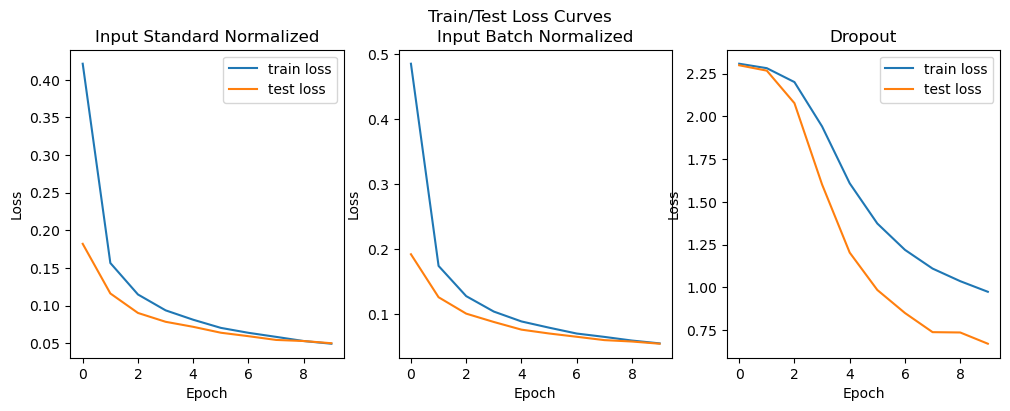

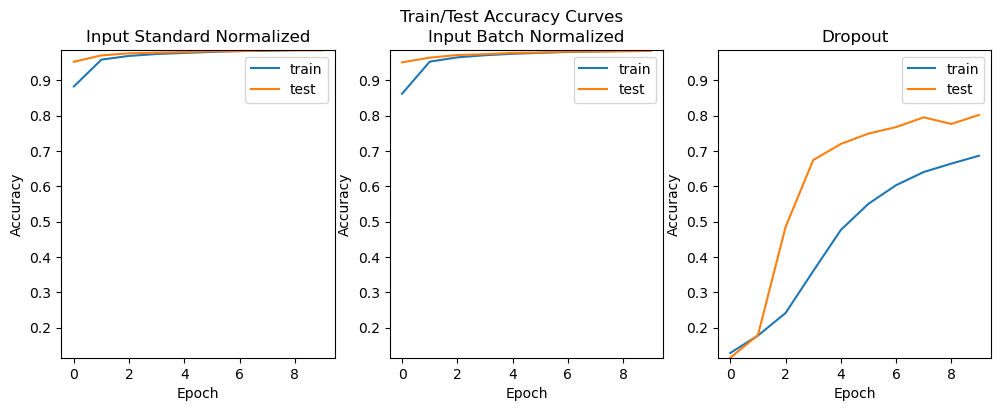

In [16]:
train_loss_m3, test_loss_m3 = historyDropout.history['loss'], historyDropout.history['val_loss']
train_accuracy_m3, test_accuracy_m3 = historyDropout.history['accuracy'], historyDropout.history['val_accuracy']



plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_loss_m1, label='train loss')
plt.plot(test_loss_m1, label='test loss')
# plt.ylim(ymin, ymax)
plt.title('Input Standard Normalized')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_loss_m2, label='train loss')
plt.plot(test_loss_m2, label='test loss')
# plt.ylim(ymin, ymax)
plt.title('Input Batch Normalized')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
plt.plot(train_loss_m3, label='train loss')
plt.plot(test_loss_m3, label='test loss')
# plt.ylim(ymin, ymax)
plt.title('Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.suptitle('Train/Test Loss Curves')



# Validation Subplots


plt.figure(figsize=(12, 4))

# ylim for both
ymin, ymax = min(min(train_accuracy_m1), min(test_accuracy_m1), min(test_accuracy_m3)), max(max(train_accuracy_m1), max(test_accuracy_m1), max(test_accuracy_m3))

plt.subplot(1, 3, 1)
plt.plot(train_accuracy_m1, label='train')
plt.plot(test_accuracy_m1, label='test')
plt.ylim(ymin, ymax)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Input Standard Normalized')

# store fig in variable to be added to later but still show now
loss_fig = plt.gcf()



plt.subplot(1, 3, 2)
plt.plot(train_accuracy_m2, label='train')
plt.plot(test_accuracy_m2, label='test')
plt.ylim(ymin, ymax)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Input Batch Normalized')


plt.subplot(1, 3, 3)
plt.plot(train_accuracy_m3, label='train')
plt.plot(test_accuracy_m3, label='test')
plt.ylim(ymin, ymax)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Dropout')


plt.suptitle('Train/Test Accuracy Curves')



In [17]:
# print loss/ acc valloss val acc per epoch
import pandas as pd
pd.DataFrame(historyDropout.history)



,loss,accuracy,val_loss,val_accuracy
0,2.307588,0.127983,2.298509,0.1145
1,2.281548,0.177233,2.267056,0.1786
2,2.200276,0.241117,2.076939,0.4847
3,1.940944,0.359800,1.601421,0.6742
4,1.608463,0.476367,1.203264,0.7199
5,1.373267,0.550450,0.984688,0.7493
6,1.219265,0.603150,0.850025,0.7677
7,1.109789,0.640400,0.738122,0.7953
8,1.036221,0.664283,0.736199,0.7765
9,0.974117,0.686517,0.670460,0.8020


We can see that the teast accuracy is lower for the dropout model than the model without dropous. 


## Part 5 - Batch Normalization With Dropout (include BN on first layer )


In [213]:


model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dropout(0.2, input_shape=(28, 28, 1)),
    layers.Conv2D(6, kernel_size=(5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),
    layers.Conv2D(16, kernel_size=(5, 5), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(120, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(84, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


x_train, y_train, x_test, y_test = get_mnist(scale=False)

with tf.device(f'/device:{device}:0'):
    historyDropoutBatch = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

pd.DataFrame(historyDropoutBatch.history)


Epoch 1/10
469/469 [==============================] - 7s 14ms/step - loss: 2.0239 - accuracy: 0.3535 - val_loss: 0.8818 - val_accuracy: 0.7574
Epoch 2/10
469/469 [==============================] - 6s 13ms/step - loss: 1.1647 - accuracy: 0.6036 - val_loss: 0.5768 - val_accuracy: 0.8385
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.9145 - accuracy: 0.6942 - val_loss: 0.4305 - val_accuracy: 0.8815
Epoch 4/10
469/469 [==============================] - 6s 13ms/step - loss: 0.7669 - accuracy: 0.7484 - val_loss: 0.3325 - val_accuracy: 0.9138
Epoch 5/10
469/469 [==============================] - 6s 14ms/step - loss: 0.6721 - accuracy: 0.7830 - val_loss: 0.2779 - val_accuracy: 0.9265
Epoch 6/10
469/469 [==============================] - 6s 14ms/step - loss: 0.6193 - accuracy: 0.8022 - val_loss: 0.2486 - val_accuracy: 0.9322
Epoch 7/10
469/469 [==============================] - 6s 13ms/step - loss: 0.5672 - accuracy: 0.8190 - val_loss: 0.2298 - val_accuracy: 0.9362

,loss,accuracy,val_loss,val_accuracy
0,2.023889,0.353483,0.881779,0.7574
1,1.164655,0.603600,0.576766,0.8385
2,0.914526,0.694167,0.430504,0.8815
3,0.766868,0.748433,0.332450,0.9138
4,0.672090,0.783000,0.277931,0.9265
5,0.619260,0.802217,0.248643,0.9322
6,0.567187,0.818983,0.229813,0.9362
7,0.527264,0.831933,0.206068,0.9405
8,0.507927,0.841217,0.188497,0.9441
9,0.475987,0.850733,0.181658,0.9458


Text(0.5, 0.98, 'Train/Test Accuracy Curves')

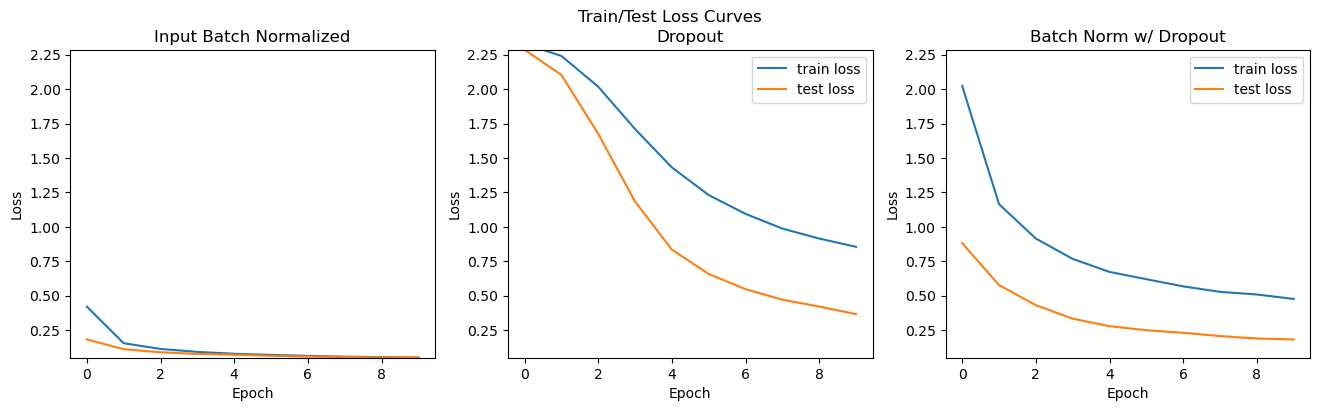

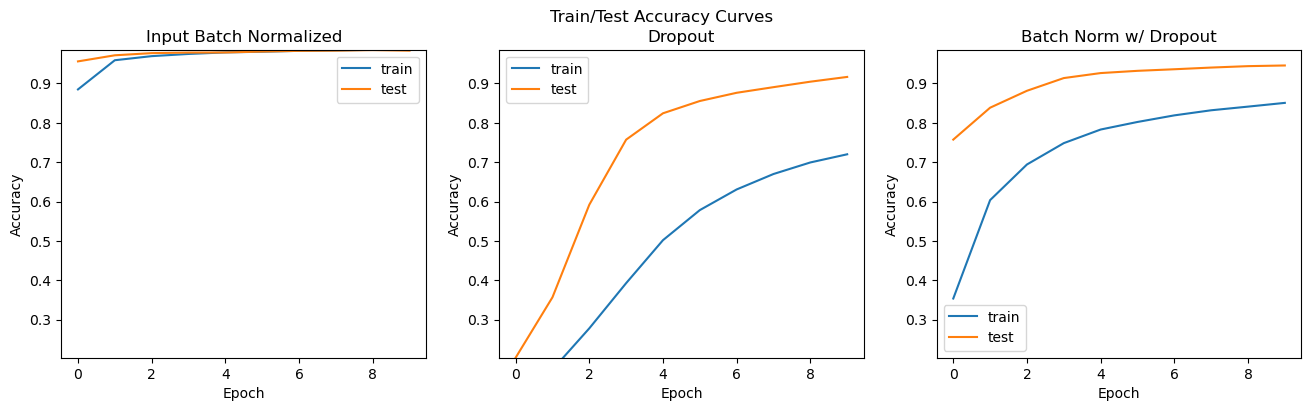

In [218]:

train_loss_m4, test_loss_m4 = historyDropoutBatch.history['loss'], historyDropoutBatch.history['val_loss']
train_accuracy_m4, test_accuracy_m4 = historyDropoutBatch.history['accuracy'], historyDropoutBatch.history['val_accuracy']


plt.figure(figsize=(16, 4))


ymin, ymax = min(min(train_loss_m2), min(test_loss_m2), min(test_loss_m3), min(test_loss_m4)), max(max(train_loss_m2), max(test_loss_m2), max(test_loss_m3), max(test_loss_m4))


plt.subplot(1, 3, 1)
plt.plot(train_loss_m2, label='train loss')
plt.plot(test_loss_m2, label='test loss')
plt.ylim(ymin, ymax)
plt.title('Input Batch Normalized')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(train_loss_m3, label='train loss')
plt.plot(test_loss_m3, label='test loss')
plt.ylim(ymin, ymax)
plt.title('Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(133)
plt.plot(train_loss_m4, label='train loss')
plt.plot(test_loss_m4, label='test loss')
plt.ylim(ymin, ymax)
plt.title('Batch Norm w/ Dropout')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



plt.suptitle('Train/Test Loss Curves')



# Validation Subplots


plt.figure(figsize=(16, 4))

# ylim for both
ymin, ymax = min(min(train_accuracy_m1), min(test_accuracy_m1), min(test_accuracy_m3)), max(max(train_accuracy_m1), max(test_accuracy_m1), max(test_accuracy_m3))

plt.subplot(1, 3, 1)
plt.plot(train_accuracy_m2, label='train')
plt.plot(test_accuracy_m2, label='test')
plt.ylim(ymin, ymax)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.title('Input Batch Normalized')


plt.subplot(1, 3, 2)
plt.plot(train_accuracy_m3, label='train')
plt.plot(test_accuracy_m3, label='test')
plt.ylim(ymin, ymax)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Dropout')

plt.subplot(1, 3, 3)
plt.plot(train_accuracy_m4, label='train')
plt.plot(test_accuracy_m4, label='test')
plt.ylim(ymin, ymax)
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Batch Norm w/ Dropout')




plt.suptitle('Train/Test Accuracy Curves')



The test accuracy is higher than simply dropout alone, however, it is lower than the first two models.
